# Imports

In [67]:
from importlib import reload
import json
import logging
import time
from argparse import ArgumentParser
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import datasets
from model import CNN, MyDartsTrainer

import utils

# Hyperparameters

In [68]:
layers = 1
batch_size = 64
log_frequency = 40
channels = 16
unrolled = False
visualization = False

# Getting dataset

In [69]:
dataset = "fashionmnist"

dataset_train, dataset_valid = datasets.get_dataset(dataset)        

# Architecture search for a range of $\lambda$

In [70]:
logs = {}

In [71]:
import numpy as np
def warmup_weight(epoch, epochs):
    minim, maxim = 0, 0.2
    return minim + (epoch / epochs) * (maxim - minim)

def warmup_t(epoch, epochs):
    minim, maxim = 0.01, 1
    return maxim - (epoch / epochs) * (maxim - minim)

weight = yes, temoreture = yes lambd = 1
Epoch [1/10] Step [1/469]  acc1 0.093750 (0.093750)  loss 2.290469 (2.290469)
Epoch [1/10] Step [41/469]  acc1 0.515625 (0.261433)  loss 1.376690 (1.912979)
Epoch [1/10] Step [81/469]  acc1 0.640625 (0.396412)  loss 1.168001 (1.613947)
Epoch [1/10] Step [121/469]  acc1 0.671875 (0.471720)  loss 1.076160 (1.433621)
Epoch [1/10] Step [161/469]  acc1 0.625000 (0.517275)  loss 0.862634 (1.316244)
Epoch [1/10] Step [201/469]  acc1 0.718750 (0.555892)  loss 0.788739 (1.219121)
Epoch [1/10] Step [241/469]  acc1 0.718750 (0.580978)  loss 0.765414 (1.154404)
Epoch [1/10] Step [281/469]  acc1 0.718750 (0.597754)  loss 0.737075 (1.107764)
Epoch [1/10] Step [321/469]  acc1 0.765625 (0.614437)  loss 0.685203 (1.066778)
Epoch [1/10] Step [361/469]  acc1 0.781250 (0.629458)  loss 0.627376 (1.025491)
Epoch [1/10] Step [401/469]  acc1 0.750000 (0.641716)  loss 0.843794 (0.994424)
Epoch [1/10] Step [441/469]  acc1 0.765625 (0.652317)  loss 0.671412 (0.964910)
Epo

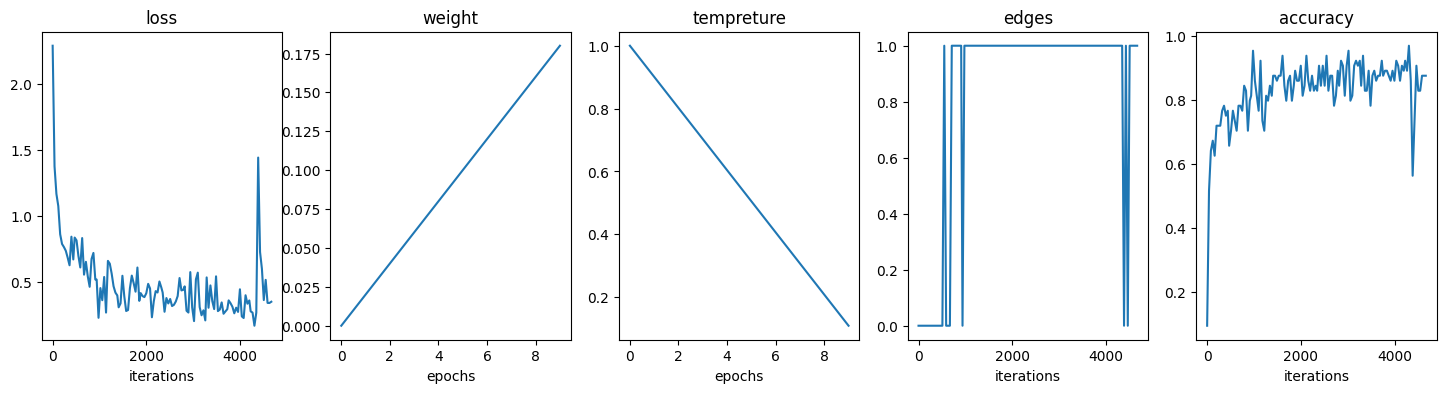

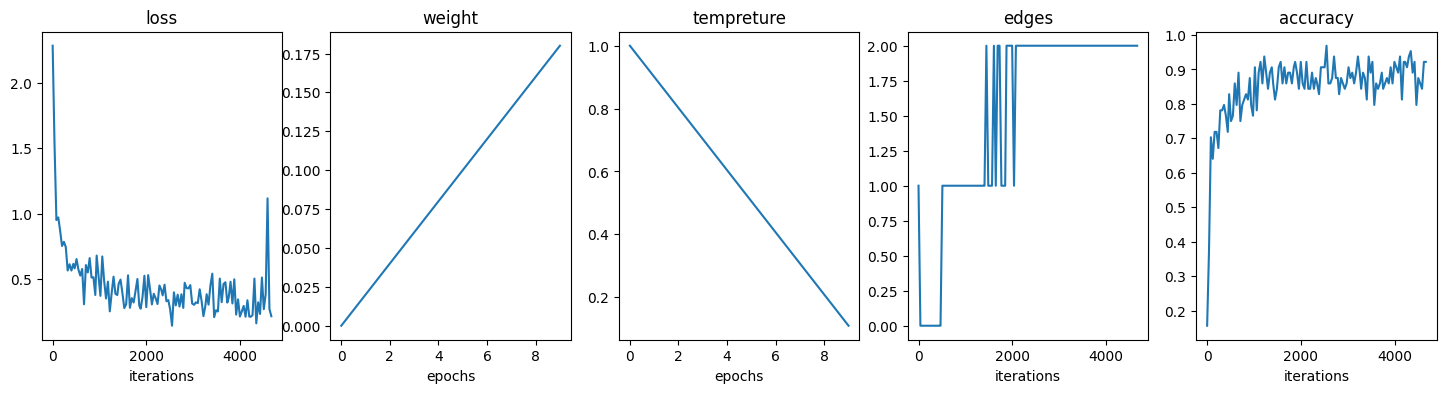

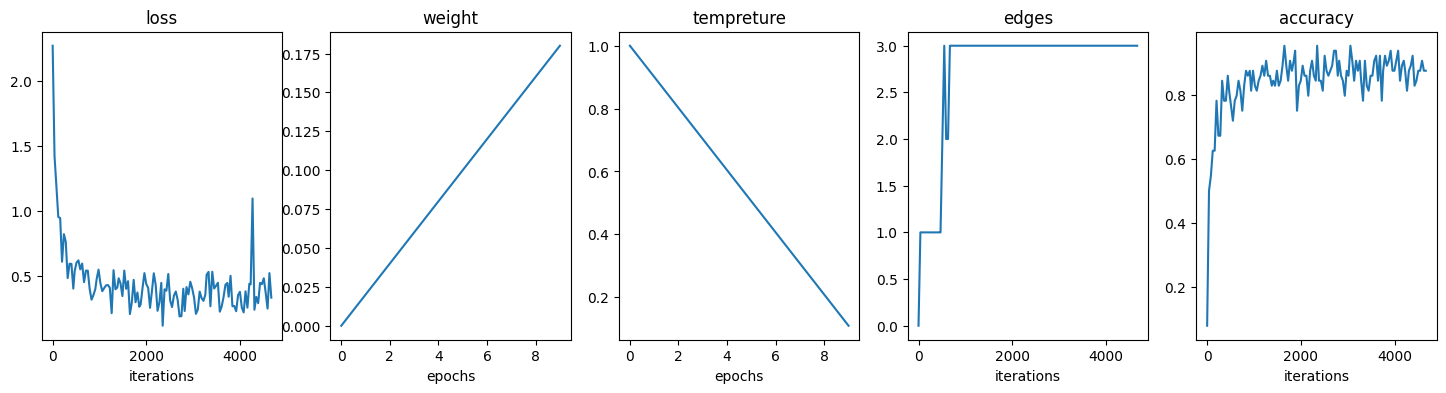

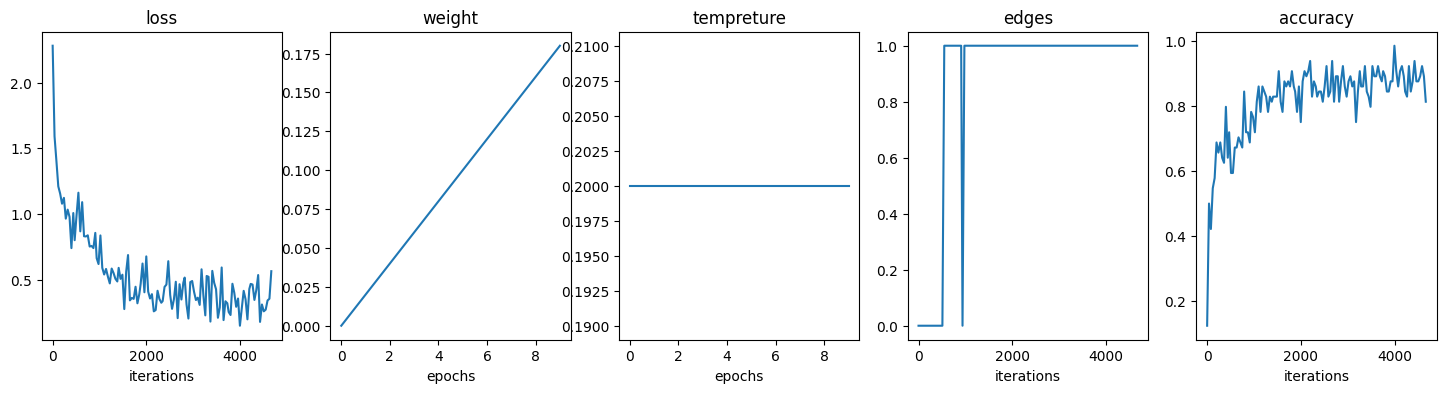

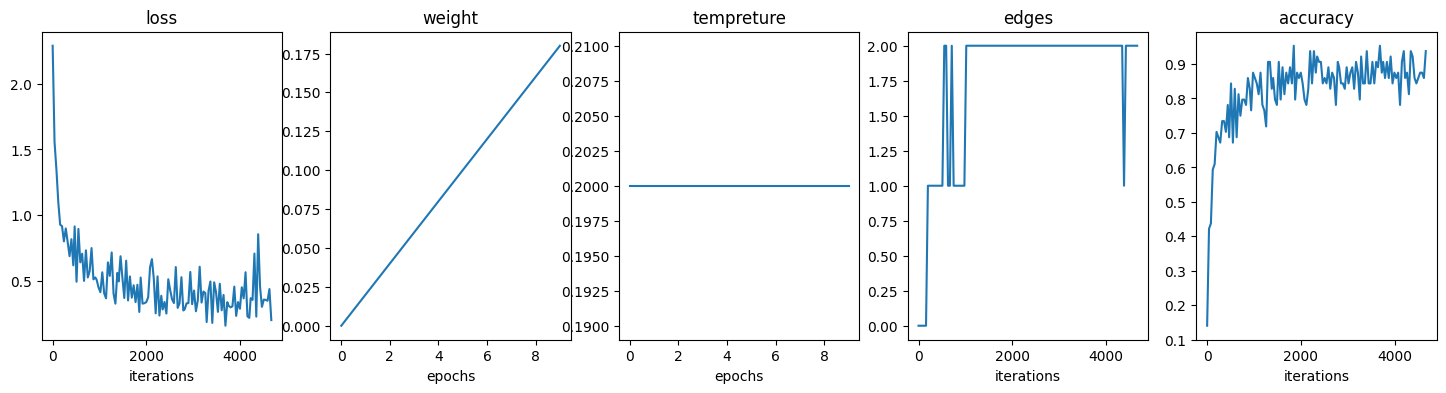

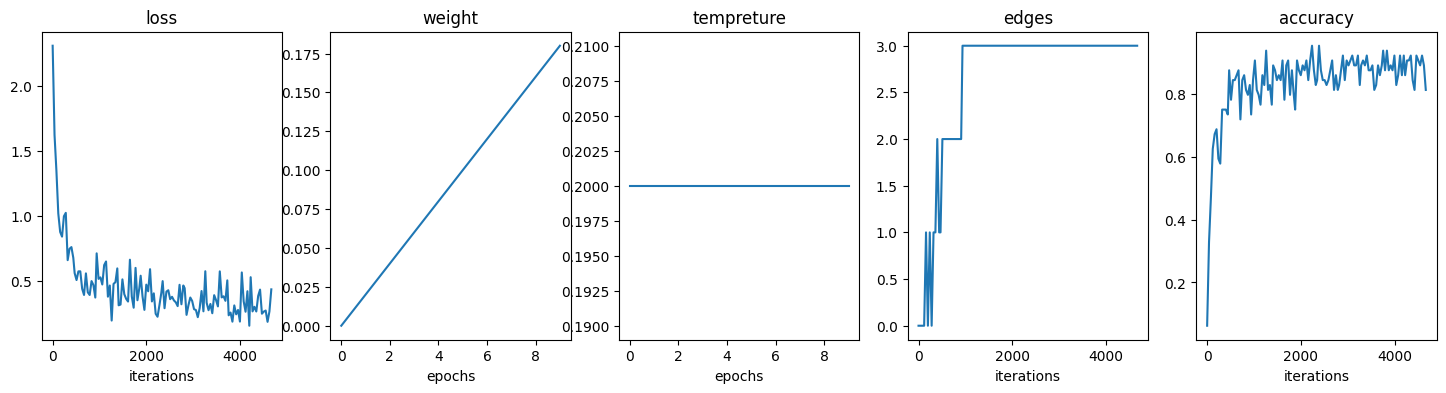

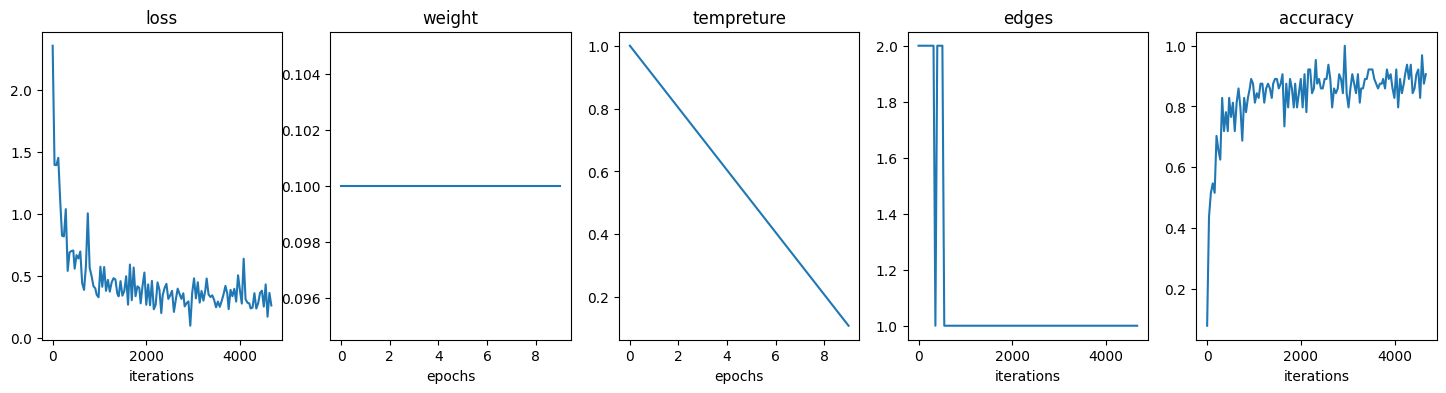

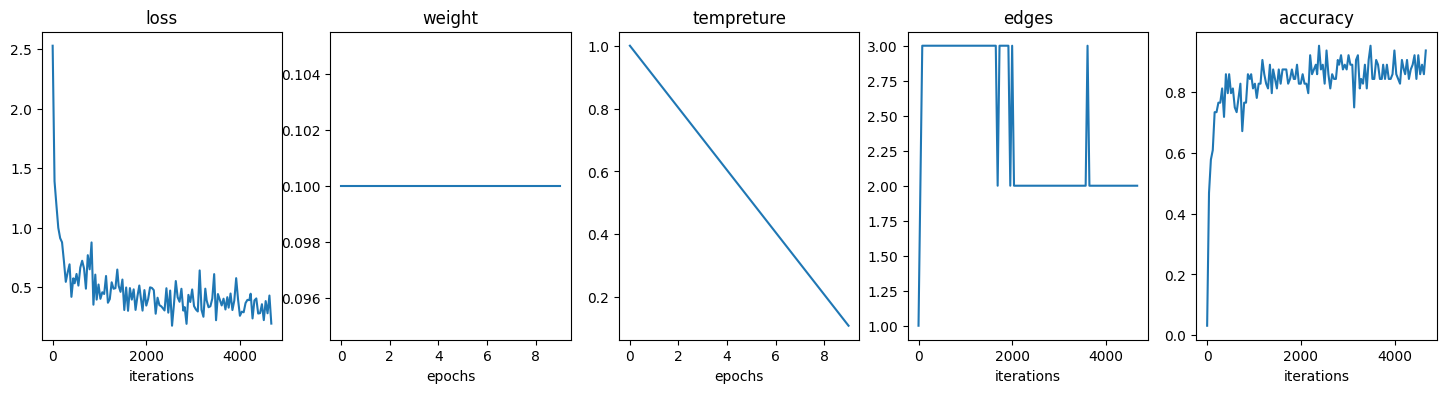

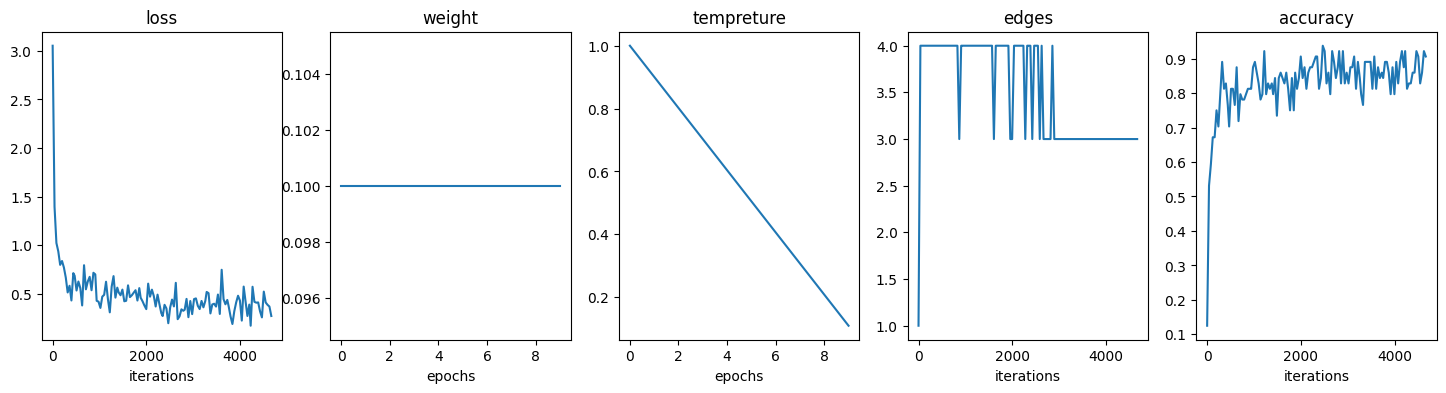

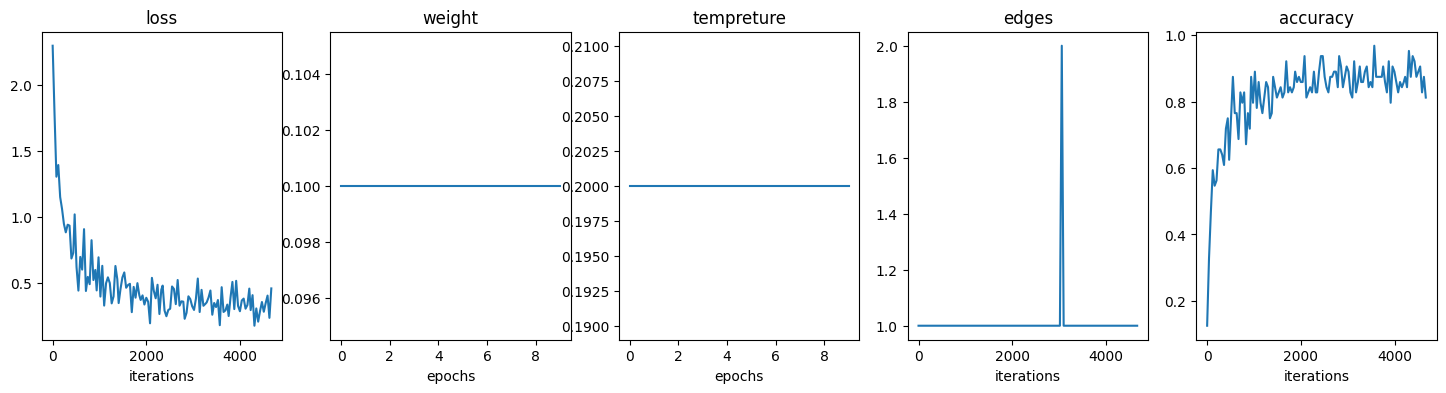

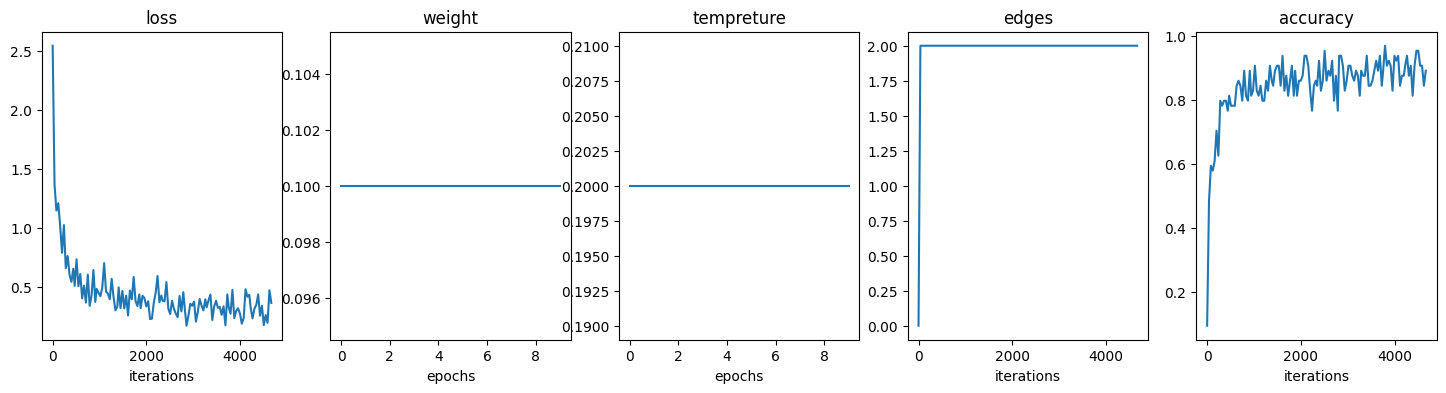

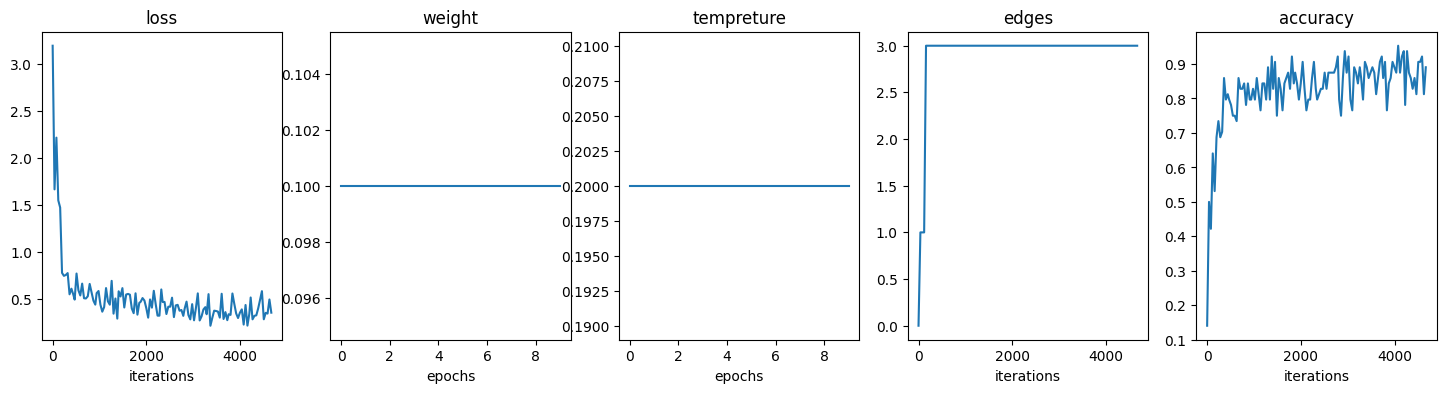

In [72]:
epochs = 10
lambd = 1
n_chosen = 1
weight = 0.1
for ww in [warmup_weight, None]:
    for wt in [warmup_t, None]:
        for lambd in [1, 2, 3]:
            wr = utils.Writer()
            wr.new_name('loss')
            wr.new_name('weight')
            wr.new_name('tempreture')
            wr.new_name('edges')
            wr.new_name('accuracy')

            ww_label = "no" if ww is None else "yes"
            wt_label = "no" if wt is None else "yes"

            print(f"weight = {ww_label}, temoreture = {wt_label} lambd = {lambd}")
            if dataset == "fashionmnist":
                model = CNN(32, 1, channels, 10, layers, n_chosen=1)
            if dataset == "cifar10":
                model = CNN(32, 3, channels, 10, layers, n_chosen=1)

            criterion = nn.CrossEntropyLoss() # mycriterion()
            optim = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
            lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs, eta_min=0.001)
            trainer = MyDartsTrainer(
                model=model,
                loss=criterion, # =mycriterion,
                metrics=lambda output, target: utils.accuracy(output, target, topk=(1,)),
                optimizer=optim,
                num_epochs=epochs,
                dataset=dataset_train,
                batch_size=batch_size,
                log_frequency=log_frequency,
                unrolled=unrolled,
                weight=weight, # вес регуляризатора
                lambd=lambd, # количество общих ребер
                train_as_optimal=False,
                optimalPath='checkpoints/fashionMNIST/optimal/arc.json',
                tau=1.0,
                learning_rate=2.5E-3,
                arc_learning_rate=3.0E-1,
                n_chosen=1,
                t_alpha=0.2,
                t_beta=0.2,
            )
            trainer.fit(writer=wr, warmup_t=wt, warmup_weight=ww)
            final_architecture = trainer.export()
            print('Final architecture:', final_architecture)
            json.dump(trainer.export(), open(f'checkpoints/fashionMNIST/lambd={lambd}/ww={ww_label}wt={wt_label}/arc7.json', 'w+'))
            # json.dump(trainer.export(), open(f"checkpoints/lambd={lambd}" + '/arc.json', 'w+'))
            logs.update({ f'lambd={lambd}, weight={ww_label}, tempreture={wt_label}' : wr })
            wr.show()

In [46]:
arcs = [{'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'avgpool', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'skipconnect', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'dilconv3x3', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'sepconv3x3', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'dilconv5x5', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [0], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [4]},
{'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'avgpool', 'reduce_n3_p0': 'maxpool', 'reduce_n3_p1': 'dilconv5x5', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'dilconv3x3', 'reduce_n4_p1': 'maxpool', 'reduce_n4_p2': 'avgpool', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'avgpool', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'skipconnect', 'reduce_n5_p4': 'dilconv3x3', 'reduce_n2_switch': [0], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [4]},
{'reduce_n2_p0': 'sepconv3x3', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'avgpool', 'reduce_n3_p1': 'maxpool', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'avgpool', 'reduce_n4_p1': 'dilconv3x3', 'reduce_n4_p2': 'avgpool', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'sepconv3x3', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'skipconnect', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'maxpool', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv3x3', 'reduce_n3_p1': 'skipconnect', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'avgpool', 'reduce_n4_p1': 'dilconv3x3', 'reduce_n4_p2': 'skipconnect', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'dilconv5x5', 'reduce_n5_p1': 'dilconv3x3', 'reduce_n5_p2': 'dilconv3x3', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'sepconv5x5', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'maxpool', 'reduce_n4_p0': 'skipconnect', 'reduce_n4_p1': 'dilconv5x5', 'reduce_n4_p2': 'dilconv3x3', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'dilconv3x3', 'reduce_n5_p1': 'maxpool', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'skipconnect', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [2]},
{'reduce_n2_p0': 'sepconv3x3', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'skipconnect', 'reduce_n3_p1': 'sepconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'dilconv3x3', 'reduce_n4_p1': 'dilconv3x3', 'reduce_n4_p2': 'dilconv5x5', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'sepconv5x5', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'avgpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [4]},
{'reduce_n2_p0': 'skipconnect', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'sepconv3x3', 'reduce_n3_p2': 'avgpool', 'reduce_n4_p0': 'dilconv5x5', 'reduce_n4_p1': 'dilconv5x5', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'sepconv3x3', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'dilconv5x5', 'reduce_n2_switch': [1], 'reduce_n3_switch': [0], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'skipconnect', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'avgpool', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'dilconv3x3', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'skipconnect', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'maxpool', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'skipconnect', 'reduce_n3_p2': 'maxpool', 'reduce_n4_p0': 'dilconv5x5', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'maxpool', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'sepconv3x3', 'reduce_n5_p1': 'dilconv3x3', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'sepconv5x5', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'skipconnect', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'maxpool', 'reduce_n3_p1': 'dilconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'maxpool', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'skipconnect', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'dilconv5x5', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [4]},
{'reduce_n2_p0': 'skipconnect', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv3x3', 'reduce_n3_p1': 'dilconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'sepconv3x3', 'reduce_n4_p1': 'maxpool', 'reduce_n4_p2': 'maxpool', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'dilconv3x3', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'skipconnect', 'reduce_n5_p3': 'sepconv3x3', 'reduce_n5_p4': 'sepconv3x3', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'maxpool', 'reduce_n4_p1': 'dilconv5x5', 'reduce_n4_p2': 'maxpool', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'maxpool', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'dilconv5x5', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'sepconv3x3', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'maxpool', 'reduce_n4_p0': 'dilconv5x5', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'sepconv3x3', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'dilconv3x3', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'skipconnect', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'dilconv5x5', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'sepconv3x3', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'skipconnect', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'avgpool', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'sepconv5x5', 'reduce_n2_switch': [0], 'reduce_n3_switch': [2], 'reduce_n4_switch': [0], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'dilconv3x3', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv3x3', 'reduce_n3_p1': 'avgpool', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'skipconnect', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'dilconv5x5', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'avgpool', 'reduce_n5_p4': 'skipconnect', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [4]},
{'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'skipconnect', 'reduce_n4_p1': 'avgpool', 'reduce_n4_p2': 'dilconv3x3', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'avgpool', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'dilconv3x3', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'dilconv5x5', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]}]
arcs1 = [arcs[0], arcs[4], arcs[8], arcs[12]]
arcs2 = [arcs[1], arcs[5], arcs[9], arcs[13]]
arcs3 = [arcs[2], arcs[6], arcs[10], arcs[14]]
arcs4 = [arcs[3], arcs[7], arcs[11], arcs[15]]
all_intersections = []
arcs = arcs4
with open(f'checkpoints/fashionMNIST/optimal/arc.json') as f:
    arc = json.load(f)
    arcs.append(arc)
for arc in arcs:
    intersections = []
    for other_arc in arcs:
        intersections.append(utils.common_edges(arc, other_arc))

    all_intersections.append(intersections)
for i in all_intersections:
    print(i)

[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4]


In [73]:
for log in logs:
    print(log, np.mean(logs[log].get('accuracy')[1][-5:]))

lambd=1, weight=yes, tempreture=yes 0.85625
lambd=2, weight=yes, tempreture=yes 0.884375
lambd=3, weight=yes, tempreture=yes 0.88125
lambd=1, weight=yes, tempreture=no 0.878125
lambd=2, weight=yes, tempreture=no 0.88125
lambd=3, weight=yes, tempreture=no 0.884375
lambd=1, weight=no, tempreture=yes 0.9
lambd=2, weight=no, tempreture=yes 0.89375
lambd=3, weight=no, tempreture=yes 0.884375
lambd=1, weight=no, tempreture=no 0.8625
lambd=2, weight=no, tempreture=no 0.9
lambd=3, weight=no, tempreture=no 0.8875


## Common edges

In [74]:
arcs = []

with open(f'checkpoints/fashionMNIST/optimal/arc.json') as f:
    arc = json.load(f) # оптимальная архитектура в виде словаря
    arcs.append(arc)

lambds = [1, 2, 3, 4]
for lamb in lambds:
    with open(f'checkpoints/fashionMNIST/lambd={lamb}/arc.json') as f:
        arc = json.load(f)
        arcs.append(arc)

all_intersections = []
for arc in arcs:
    intersections = []
    for other_arc in arcs:
        intersections.append(utils.common_edges(arc, other_arc))

    all_intersections.append(intersections)
intersections_with_opt = all_intersections[0]
print(intersections_with_opt)

[4, 1, 2, 3, 4]


Text(0.5, 0, 'lambda')

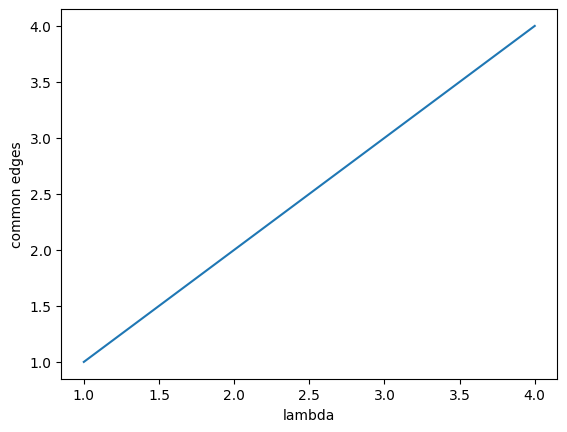

In [13]:
y = intersections_with_opt[1:]
plt.plot(lambds, y)
plt.ylabel('common edges')
plt.xlabel('lambda')

## Retrain

In [75]:
layers = 2
batch_size = 96
log_frequency = 20
channels = 16
unrolled = False
visualization = False

In [76]:
from retrain import train, validate, fixed_arch
# reload(train)

config = {
'layers' : layers,
'batch_size' : batch_size,
'log_frequency' : log_frequency,
'epochs' : 10,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
'save_folder' : "./checkpoints/fashionMNIST/",
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_train, dataset_valid = datasets.get_dataset("fashionmnist", cutout_length=16)

best_top1s = {}
for ww in [warmup_weight, None]:
    for wt in [warmup_t, None]:
        ww_label = "no" if ww is None else "yes"
        wt_label = "no" if wt is None else "yes"
        for lambd in [1, 2, 3]:
            if lambd == 0:
                folder = config['save_folder'] + "optimal/"
            else:
                folder = config['save_folder'] + f"lambd={lambd}/ww={ww_label}wt={wt_label}/"
            print(folder)
            with fixed_arch(folder + 'arc7.json'):
            # with fixed_arch(args.save_folder + "/arc.json"):
                model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True)

            criterion = nn.CrossEntropyLoss()

            model.to(device)
            criterion.to(device)

            optimizer = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
            lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'], eta_min=1E-6)

            train_loader = torch.utils.data.DataLoader(dataset_train,
                                                    batch_size=config['batch_size'],
                                                    shuffle=True,
                                                    num_workers=config['workers'],
                                                    pin_memory=True)
            valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                                    batch_size=config['batch_size'],
                                                    shuffle=False,
                                                    num_workers=config['workers'],
                                                    pin_memory=True)

            best_top1 = 0.
            for epoch in range(config['epochs']):
                drop_prob = config['drop_path_prob'] * epoch / config['epochs']
                model.drop_path_prob(drop_prob)

                # training
                train(config, train_loader, model, optimizer, criterion, epoch)

                # validation
                cur_step = (epoch + 1) * len(train_loader)
                top1 = validate(config, valid_loader, model, criterion, epoch, cur_step)
                best_top1 = max(best_top1, top1)

                lr_scheduler.step()

            torch.save(model.state_dict(), folder + "mod7.json")
            # torch.save(model.state_dict(), args.save_folder + "/mod.json")
            print("Final best Prec@1 = {:.4%}".format(best_top1))
            best_top1s.update({f'lambd={lambd}, ww={ww_label}, wt={wt_label}' : best_top1})
            print(best_top1s)

./checkpoints/fashionMNIST/lambd=1/ww=yeswt=yes/
[2023-11-30 10:23:06] Fixed architecture: {'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'skipconnect', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'maxpool', 'reduce_n3_p2': 'sepconv3x3', 'reduce_n4_p0': 'avgpool', 'reduce_n4_p1': 'avgpool', 'reduce_n4_p2': 'dilconv3x3', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'sepconv3x3', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'avgpool', 'reduce_n5_p3': 'sepconv5x5', 'reduce_n5_p4': 'dilconv5x5', 'reduce_n2_switch': [0], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [1]}
[2023-11-30 10:23:06] Epoch 0 LR 0.025000
[2023-11-30 10:23:07] Train: [  1/10] Step 000/624 Loss 3.262 Prec@(1,5) (15.6%, 49.0%)
[2023-11-30 10:23:08] Train: [  1/10] Step 020/624 Loss 2.824 Prec@(1,5) (26.5%, 67.1%)
[2023-11-30 10:23:08] Train: [  1/10] Step 040/624 Loss 2.381 Prec@(1,5) (35.5%, 80.5%)
[2023-11-30 10:23:09] Train: [  1/10] Step 060/624 Loss 2.128 Prec@(1,5) (41.6%, 86.0%)
[2023

In [66]:
for ww in ['yes', 'no']:
    for wt in ['yes', 'no']:
        for l in [1, 2, 3]:
            print(ww, wt, l, best_top1s[f'lambd={l}, ww={ww}, wt={wt}'])

yes yes 1 0.9128000188827514
yes yes 2 0.8859000228881836
yes yes 3 0.8945000186920166
yes no 1 0.893200019645691
yes no 2 0.9128000177383423
yes no 3 0.917300020980835
no yes 1 0.8970000190734864
no yes 2 0.9106000173568726
no yes 3 0.9007000192642212
no no 1 0.9167000211715698
no no 2 0.8997000205993653
no no 3 0.9038000221252441


## Validation

In [17]:
import numpy as np
from glob import glob
from nni.retiarii.oneshot.pytorch.utils import AverageMeter
from torch.utils.tensorboard import SummaryWriter

logger = logging.getLogger('nni')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

config = {
'layers' : 2,
'batch_size' : 96,
'log_frequency' : 30,
'epochs' : 10,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
'save_folder' : "./checkpoints/fashionMNIST/",
}

dataset_train, dataset_valid = datasets.get_dataset("fashionmnist", cutout_length=16)

res_dict_accur = {}
models = []

# chosen_lambdas = np.random.choice(8, size=3, replace=False) # выбранные lambda
chosen_lambdas = (1, 2, 3)

print(chosen_lambdas)

for dir in glob(config['save_folder'] + "*"):
    if dir.split('\\')[-1] != 'optimal' and float(dir.split('\\')[-1].split('=')[-1]) in chosen_lambdas:
    # if dir == "./checkpoints\\0":
        print(dir)
        with fixed_arch(dir + "/arc.json"):
            model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True, n_chosen=n_chosen)
        model.to(device)
        model.load_state_dict(torch.load(dir + "/mod.json"))
        model.eval()
        
        models.append(model)

print(f"Models in ensemble: {len(models)}")

valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                            batch_size=config['batch_size'],
                                            shuffle=False,
                                            num_workers=config['workers'],
                                            pin_memory=True)
criterion = nn.CrossEntropyLoss()

top1 = AverageMeter("top1")
top5 = AverageMeter("top5")
losses = AverageMeter("losses")

# validation
softmax = nn.Softmax(dim=1)
for step, (X, y) in enumerate(valid_loader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        bs = X.size(0)

        probabilities = softmax(models[0](X))
        for i in range(1, len(models)):
            probabilities += softmax(models[i](X))
        probabilities = probabilities / len(models)
        loss = criterion(probabilities, y)

        accuracy = utils.accuracy(probabilities, y, topk=(1, 5))
        losses.update(loss.item(), bs)
        top1.update(accuracy["acc1"], bs)
        top5.update(accuracy["acc5"], bs)

        if step % config['log_frequency'] == 0 or step == len(valid_loader) - 1:
            logger.info(
                "Valid: Step {:03d}/{:03d} Loss {losses.avg:.3f} "
                "Prec@(1,5) ({top1.avg:.1%}, {top5.avg:.1%})".format(
                    step, len(valid_loader) - 1, losses=losses,
                    top1=top1, top5=top5))

logger.info("Final best Prec@1 = {:.4%}".format(top1.avg))

res_dict_accur[chosen_lambdas] = top1.avg
print(res_dict_accur)

(1, 2, 3)
./checkpoints/fashionMNIST\lambd=1
[2023-11-09 16:55:46] Fixed architecture: {'reduce_n2_p0': 'maxpool', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'dilconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'skipconnect', 'reduce_n4_p0': 'dilconv5x5', 'reduce_n4_p1': 'dilconv5x5', 'reduce_n4_p2': 'skipconnect', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'skipconnect', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'avgpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [1], 'reduce_n4_switch': [3], 'reduce_n5_switch': [2]}
./checkpoints/fashionMNIST\lambd=2
[2023-11-09 16:55:47] Fixed architecture: {'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'dilconv5x5', 'reduce_n3_p1': 'dilconv5x5', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'avgpool', 'reduce_n4_p1': 'sepconv3x3', 'reduce_n4_p2': 'dilconv5x5', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'avgpool', 'reduce_n5_p1': 'dilconv5x5', 'r